### Business case of Sibur raw materials forecasting

Raw materials is a mixture of liquefied hydrocarbon gases supplied to the SIBUR petrochemical plants via the pipeline. The pipeline is filled at several pumping stations, located in series on the way to the consumer. Composition of mixture changes at each station over time. Reliable prediction allows to optimize some technological processes

**Input data**:
raw material flow (ton per hour) at pumping station (A_rate) and consumer side (B_rate), mass percentages of components at pumping station (A_CH4, A_C2H6, A_C3H8, A_iC4H10, A_nC4H10, A_iC5H12, A_nC5H12, A_C6H14).

**Target Variables**: 
Mass percentages of components at consumer side (B_C2H6, B_C3H8, B_iC4H10, B_nC4H10).

Web page about challenge and the task (in Russian): https://sibur.ai-community.com/competitions/4/tasks/11


### Imports

In [1]:
import pandas as pd
import numpy as np

from funcy import rcompose

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [3]:
from metrics import mean_absolute_percentage_error
from load_data import load_data
from constants import FEATURE_COLUMNS, FEATURE_GASES, TARGET_COLUMNS
from result_view import show_results
from processing import (clean_outliers, 
                       fill_na_train,
                       fill_na_test,
                       smooth_median_test,
                       smooth,
                       add_specified_features,
                       generate_shifts)

### Load and view raw data 

In [4]:
train_features, train_targets, test_features = load_data()

In [5]:
train_features.head()

,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
timestamp,,,,,,,,,,
2020-01-01 00:00:00,70.855017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.982789
2020-01-01 00:30:00,70.826582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.965098
2020-01-01 01:00:00,70.809637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.867409
2020-01-01 01:30:00,69.994748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.839126
2020-01-01 02:00:00,70.072762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.336921


In [6]:
train_targets.head()

,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
timestamp,,,,
2020-01-01 00:00:00,4.561979,39.015486,17.250740,24.301793
2020-01-01 00:30:00,4.550741,39.048915,17.229506,24.257461
2020-01-01 01:00:00,4.506793,38.766378,17.171621,24.236298
2020-01-01 01:30:00,4.584963,39.069360,17.218521,24.149843
2020-01-01 02:00:00,4.607483,38.817579,17.108668,24.049510


In [7]:
test_features.head()

,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
timestamp,,,,,,,,,,
2020-05-01 00:00:00,71.428342,0.267832,5.135159,36.816480,16.632260,24.062587,5.696004,4.939430,6.395286,74.273009
2020-05-01 00:30:00,70.925118,0.268464,5.149646,36.869023,16.651870,24.069800,5.676384,4.911872,6.346957,74.061833
2020-05-01 01:00:00,70.991719,0.270641,5.154615,37.074965,16.710967,24.106152,5.574873,4.808516,6.242636,73.856268
2020-05-01 01:30:00,70.972406,0.275241,5.230661,37.384180,16.683337,24.021993,5.514843,4.730887,6.101647,73.750744
2020-05-01 02:00:00,70.980078,0.275062,5.241437,37.448587,16.663863,24.003237,5.524898,4.728882,6.057119,73.698447


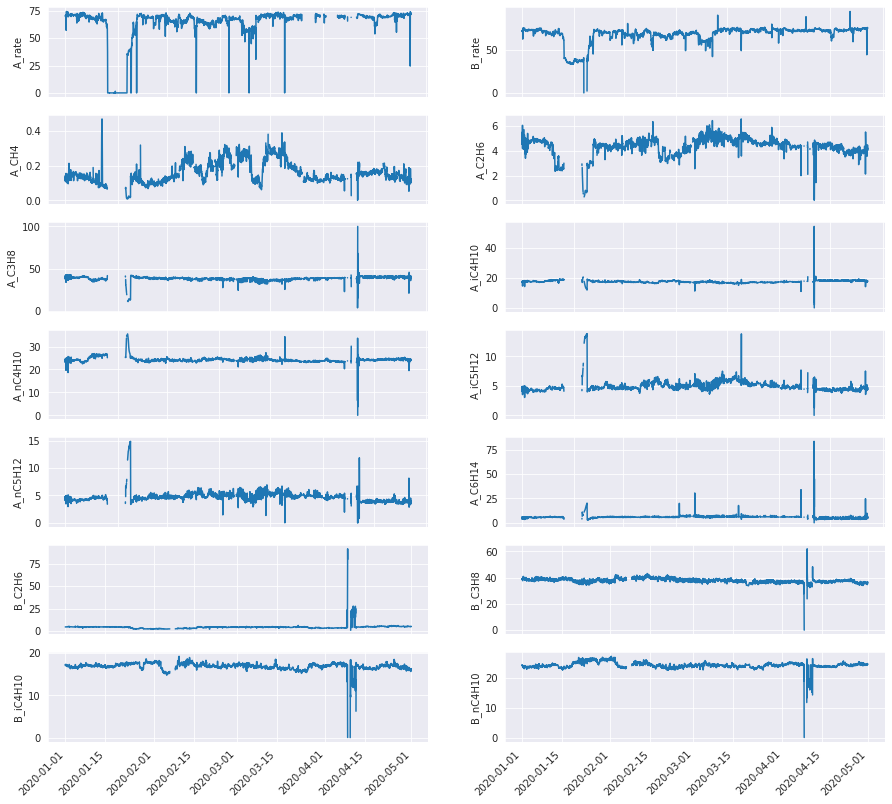

In [8]:
train_df = pd.concat([train_features, train_targets], axis=1)
df = pd.concat([train_df, test_features], axis=0)

with sns.axes_style('darkgrid'):
    figure, axes = plt.subplots(7, 2, figsize=(15, 15))
    axes = axes.flatten()
    figure.autofmt_xdate(rotation=45)
    for ax, variable_name in zip(axes, FEATURE_COLUMNS + TARGET_COLUMNS):
        ax.plot(df[variable_name], label=variable_name)
        ax.set_ylabel(variable_name)

In [9]:
# # for interactive analysis

# fig = go.Figure()

# for target in TARGET_COLUMNS:
#     gas = target[2:]
#     fig.add_trace(go.Scatter(x=train_targets.index, y=train_targets[target], name=target))
#     fig.add_trace(go.Scatter(x=train_features.index, y=train_features[f"A_{gas}"], name=f"A_{gas}"))
#     fig.add_trace(go.Scatter(x=test_features.index, y=test_features[f"A_{gas}"], name=f"A_{gas}_test"))

# fig.add_trace(go.Scatter(x=train_features.index, y=train_features["A_rate"], name="A_rate"))
# fig.add_trace(go.Scatter(x=train_features.index, y=train_features["B_rate"], name="B_rate"))

# fig.update_layout(
#     autosize=False,
#     width=1000,
#     height=400,
#     margin=dict(
#         l=50,
#         r=50,
#         b=50,
#         t=50,
#         pad=4
#     ),
#     paper_bgcolor="LightSteelBlue",
# )

# fig.show()

Note that plotly charts and legend are interactive

In [10]:
train_data = pd.concat([train_targets, train_features], axis=1)
train_data.corr().style.background_gradient(cmap='RdBu')

,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
B_C2H6,1.000000,-0.526137,-0.688247,-0.743110,0.213521,0.107325,0.310707,0.012119,-0.163176,-0.157040,-0.029578,-0.045243,0.031568,0.211150
B_C3H8,-0.526137,1.000000,0.630102,0.506293,-0.076802,-0.311324,-0.015851,0.130625,0.090394,-0.028863,-0.131563,-0.121170,-0.103876,-0.072626
B_iC4H10,-0.688247,0.630102,1.000000,0.888146,-0.031502,-0.161942,-0.069664,0.168273,0.153935,0.025477,-0.209450,-0.170436,-0.149424,-0.035976
B_nC4H10,-0.743110,0.506293,0.888146,1.000000,-0.241279,-0.053805,-0.193794,0.015706,0.162894,0.176612,-0.048697,-0.042413,-0.077840,-0.235946
A_rate,0.213521,-0.076802,-0.031502,-0.241279,1.000000,0.140528,0.437019,0.418836,0.017336,-0.430159,-0.399400,-0.367528,-0.318311,0.962491
A_CH4,0.107325,-0.311324,-0.161942,-0.053805,0.140528,1.000000,0.335366,0.200776,-0.154180,-0.337805,-0.150923,-0.155106,-0.128191,0.051154
A_C2H6,0.310707,-0.015851,-0.069664,-0.193794,0.437019,0.335366,1.000000,0.527549,-0.100987,-0.701938,-0.514814,-0.540416,-0.407348,0.341268
A_C3H8,0.012119,0.130625,0.168273,0.015706,0.418836,0.200776,0.527549,1.000000,0.486148,-0.709767,-0.940113,-0.930008,-0.881589,0.231222
A_iC4H10,-0.163176,0.090394,0.153935,0.162894,0.017336,-0.154180,-0.100987,0.486148,1.000000,0.199295,-0.645688,-0.659884,-0.686246,-0.167036
A_nC4H10,-0.157040,-0.028863,0.025477,0.176612,-0.430159,-0.337805,-0.701938,-0.709767,0.199295,1.000000,0.546690,0.523956,0.384840,-0.273329


We saw the following:

1. There is large amount of NaNs. We will need to deal with it at processing step: drop or repair with other value.
1. Data from sensors are noisy. To build robust model we will smooth  both train and test data.
1. Data has outliers because of measurement errors. We will need to prevent "Garbage in - garbage out" situation
1. There are no strong (> 0.8) correlations between input and output of gas concentration. Maybe mixture moves slowly along the pipeline and we should generate series shifts.

### Process data and generate features

Compose data process subroutines:

In [11]:
def process(data):
    return rcompose(
        clean_outliers,
        fill_na_train,
        fill_na_test,
        smooth_median_test,
        smooth,
        add_specified_features,
        generate_shifts,
    )(data)

Subroutines are:

1. clean_outliers - manual replacing of messy data to np.nan (see the definition of function)
1. fill_na_train - using rolling window to replace first np.nan's + forward/back fill of pandas for other np.nan's (see the definition of function)
1. fill_na_test - the same as fill_na_train, but back fill not used during challenge rules
1. smooth_median_test - using rolling window to replace outliers in test features
1. smooth - using exponential moving average to smooth noise from both train and test sensor data
1. add_specified_features - generate features with respect to flow rates values
1. generate_shifts - generate time shifted features

In [12]:
train_features_processed, train_targets_processed, test_features_processed = process((train_features, train_targets, test_features))

Examples of processed series:

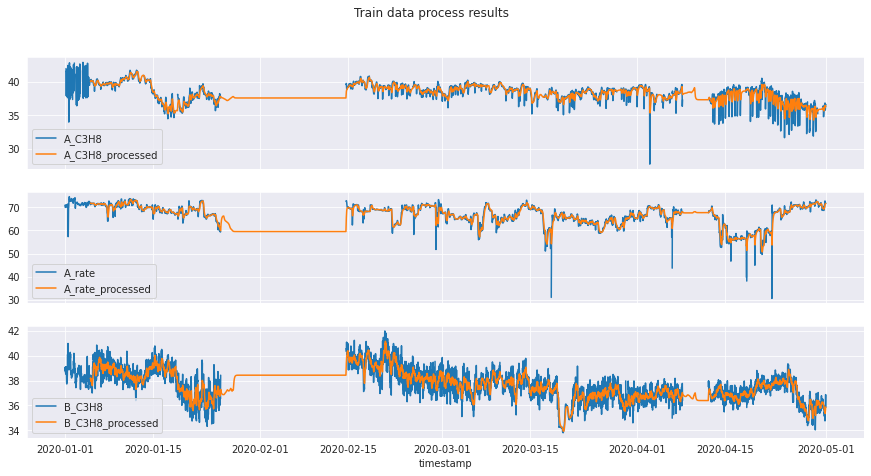

In [13]:
with sns.axes_style('darkgrid'):
    figure, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7), sharex=True)
    figure.suptitle("Train data process results")
    ax1.plot(train_features['A_C3H8'], label='A_C3H8')
    ax1.plot(train_features_processed['A_C3H8'], label='A_C3H8_processed')
    ax1.legend()
    ax2.plot(train_features['A_rate'], label='A_rate')
    ax2.plot(train_features_processed['A_rate'], label='A_rate_processed')
    ax2.legend()
    ax3.plot(train_targets['B_C3H8'], label='B_C3H8')
    ax3.plot(train_targets_processed['B_C3H8'], label='B_C3H8_processed')
    ax3.legend()
    plt.xlabel('timestamp')

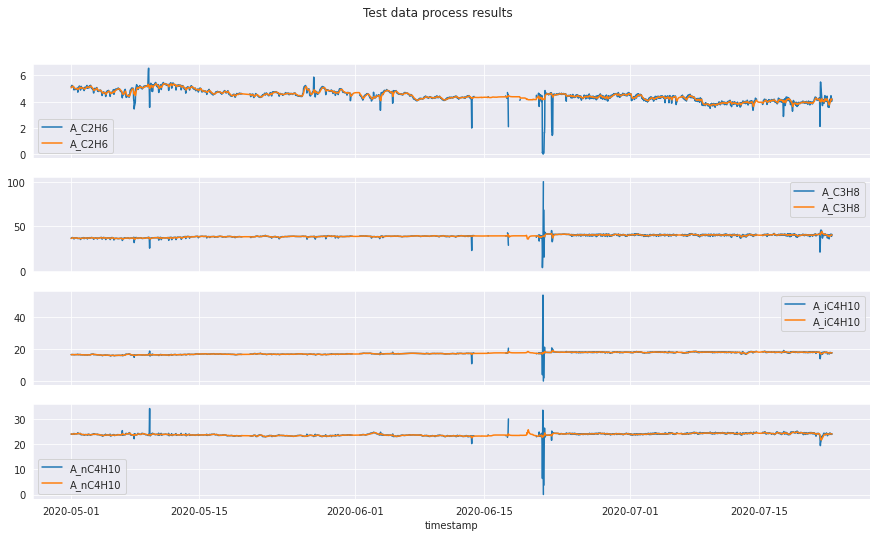

In [14]:
with sns.axes_style('darkgrid'):
    figure, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True)
    figure.suptitle("Test data process results")

    for target, ax in zip(TARGET_COLUMNS, axes):
        gas = f"A_{target[2:]}"
        ax.plot(test_features[gas], label=gas)
        ax.plot(test_features_processed[gas], label=gas)
        ax.legend()

    plt.xlabel('timestamp')

Let's look at correlations of shifted series:

In [15]:
train_data_processed = pd.concat([train_targets_processed, train_features_processed], axis=1)

In [16]:
def processed_corr_matrix(df, target):
    filter_features = []

    filter_features.append(f"{target}")
    filter_features.append(f"A_{target[2:]}_shift_175")
    filter_features.append(f"A_{target[2:]}_shift_185")
    filter_features.append(f"A_{target[2:]}_shift_195")
    filter_features.append('A_rate_shift_175')
    filter_features.append('A_rate_shift_185')
    filter_features.append('A_rate_shift_195')


    return df[filter_features].corr().style.background_gradient(cmap='RdBu')

In [17]:
target = TARGET_COLUMNS[0]
processed_corr_matrix(train_data_processed, target)

,B_C2H6,A_C2H6_shift_175,A_C2H6_shift_185,A_C2H6_shift_195,A_rate_shift_175,A_rate_shift_185,A_rate_shift_195
B_C2H6,1.000000,0.895051,0.904182,0.907131,0.269562,0.259459,0.252609
A_C2H6_shift_175,0.895051,1.000000,0.980812,0.960154,0.353140,0.348258,0.341409
A_C2H6_shift_185,0.904182,0.980812,1.000000,0.980758,0.357057,0.353093,0.348064
A_C2H6_shift_195,0.907131,0.960154,0.980758,1.000000,0.354960,0.357264,0.353138
A_rate_shift_175,0.269562,0.353140,0.357057,0.354960,1.000000,0.944966,0.881337
A_rate_shift_185,0.259459,0.348258,0.353093,0.357264,0.944966,1.000000,0.944994
A_rate_shift_195,0.252609,0.341409,0.348064,0.353138,0.881337,0.944994,1.000000


In [18]:
target = TARGET_COLUMNS[1]
processed_corr_matrix(train_data_processed, target)

,B_C3H8,A_C3H8_shift_175,A_C3H8_shift_185,A_C3H8_shift_195,A_rate_shift_175,A_rate_shift_185,A_rate_shift_195
B_C3H8,1.000000,0.456954,0.482836,0.483278,-0.050204,-0.061188,-0.073683
A_C3H8_shift_175,0.456954,1.000000,0.883457,0.851485,0.333840,0.323807,0.317796
A_C3H8_shift_185,0.482836,0.883457,1.000000,0.882695,0.354017,0.340066,0.330147
A_C3H8_shift_195,0.483278,0.851485,0.882695,1.000000,0.364520,0.360411,0.346533
A_rate_shift_175,-0.050204,0.333840,0.354017,0.364520,1.000000,0.944966,0.881337
A_rate_shift_185,-0.061188,0.323807,0.340066,0.360411,0.944966,1.000000,0.944994
A_rate_shift_195,-0.073683,0.317796,0.330147,0.346533,0.881337,0.944994,1.000000


In [19]:
target = TARGET_COLUMNS[2]
processed_corr_matrix(train_data_processed, target)

,B_iC4H10,A_iC4H10_shift_175,A_iC4H10_shift_185,A_iC4H10_shift_195,A_rate_shift_175,A_rate_shift_185,A_rate_shift_195
B_iC4H10,1.000000,0.796652,0.830243,0.842889,-0.246039,-0.254823,-0.250871
A_iC4H10_shift_175,0.796652,1.000000,0.961798,0.920528,-0.431692,-0.428482,-0.418675
A_iC4H10_shift_185,0.830243,0.961798,1.000000,0.961656,-0.422821,-0.430988,-0.427650
A_iC4H10_shift_195,0.842889,0.920528,0.961656,1.000000,-0.407099,-0.422267,-0.430293
A_rate_shift_175,-0.246039,-0.431692,-0.422821,-0.407099,1.000000,0.944966,0.881337
A_rate_shift_185,-0.254823,-0.428482,-0.430988,-0.422267,0.944966,1.000000,0.944994
A_rate_shift_195,-0.250871,-0.418675,-0.427650,-0.430293,0.881337,0.944994,1.000000


In [20]:
target = TARGET_COLUMNS[3]
processed_corr_matrix(train_data_processed, target)

,B_nC4H10,A_nC4H10_shift_175,A_nC4H10_shift_185,A_nC4H10_shift_195,A_rate_shift_175,A_rate_shift_185,A_rate_shift_195
B_nC4H10,1.000000,0.842813,0.859443,0.859998,-0.317759,-0.311487,-0.299968
A_nC4H10_shift_175,0.842813,1.000000,0.972514,0.945948,-0.409967,-0.405821,-0.399485
A_nC4H10_shift_185,0.859443,0.972514,1.000000,0.972418,-0.413450,-0.410979,-0.406835
A_nC4H10_shift_195,0.859998,0.945948,0.972418,1.000000,-0.410270,-0.414720,-0.412196
A_rate_shift_175,-0.317759,-0.409967,-0.413450,-0.410270,1.000000,0.944966,0.881337
A_rate_shift_185,-0.311487,-0.405821,-0.410979,-0.414720,0.944966,1.000000,0.944994
A_rate_shift_195,-0.299968,-0.399485,-0.406835,-0.412196,0.881337,0.944994,1.000000


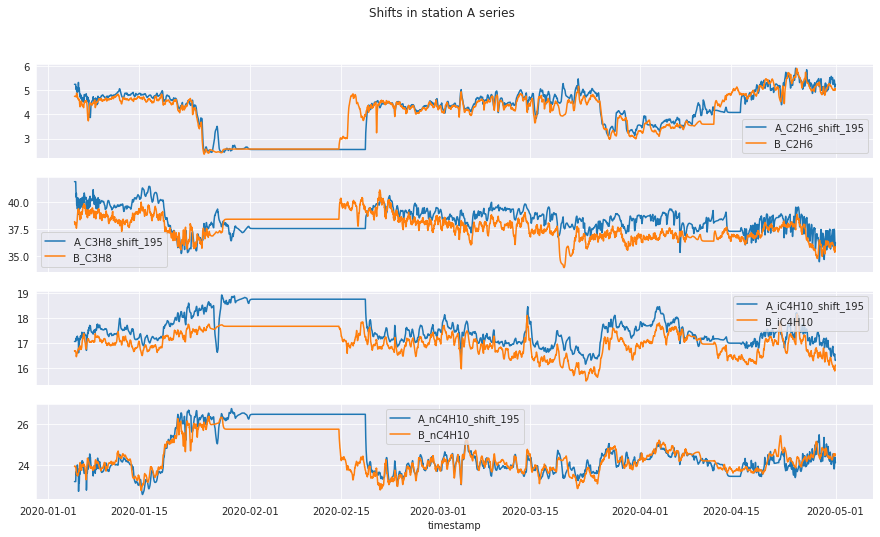

In [21]:
with sns.axes_style('darkgrid'):
    figure, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True)
    figure.suptitle("Shifts in station A series")

    for target, ax in zip(TARGET_COLUMNS, axes):
        gas = f"A_{target[2:]}"
        shifted_feature = f"A_{target[2:]}_shift_195"
        ax.plot(train_data_processed[shifted_feature], label=shifted_feature)
        ax.plot(train_data_processed[target], label=target)
        ax.legend()

    plt.xlabel('timestamp')

Processing results:

1. Mixture from station moves to consumer nearly 195 x 30 minutes = 4 days
1. Speed of mixture not constant.
1. Models should find dependency of mixture moving speed from flow rates

### Train models

In [22]:
X_train = train_features_processed
X_test = test_features_processed
X = X = pd.concat([X_train, X_test]) 
y_train = train_targets_processed

In [23]:
# hepler transform function
def pass_columns(target):
    target_gas = target[2:]
    features = [
        f"A_{target_gas}_shift_175",
        f"A_{target_gas}_shift_185",
        f"A_{target_gas}_shift_195",
        "A_rate_shift_175",
        "A_rate_shift_185",
        "A_rate_shift_195",
    ]

    def filter(X):
        return X[features]

    return filter

In [24]:
def make_simple_model(target):
    model_pipline = Pipeline([
        ("selection", FunctionTransformer(pass_columns(target))),
        ("scaler", StandardScaler()),
        ("regressor", Ridge(random_state=42))
    ])

    params_grid = {
        "regressor__alpha": np.logspace(-8, -2, num=7, base=10),
    }

    model = GridSearchCV(model_pipline,
                         params_grid,
                         scoring=make_scorer(
                             mean_absolute_percentage_error, greater_is_better=False),
                         n_jobs=-1,
                         cv=KFold(n_splits=10, shuffle=True, random_state=42),
                         refit=True,
                         return_train_score=True
                         )

    return model

In [25]:
trained_models = []
for target in TARGET_COLUMNS:
    model = make_simple_model(target)
    model = model.fit(X_train, y_train[target])
    trained_models.append(model)

In [26]:
def plot_cv_results(results, targets):
    with sns.axes_style('darkgrid'):
        _, axes = plt.subplots(2, 2, figsize=(15, 12))
        for data, target, ax in zip(results, targets, axes.flatten()):
            plot_cv_result(ax, data, target)

def plot_cv_result(ax, results, target):
    df = pd.DataFrame(results)[['param_regressor__alpha','mean_test_score','std_test_score','mean_train_score','std_train_score']]

    ax.plot(df['param_regressor__alpha'], df['mean_test_score']*-1, 'o-', color="r", label="test")
    ax.fill_between(df['param_regressor__alpha'].astype(float), 
                    df['mean_test_score']*-1 - df['std_test_score'], 
                    df['mean_test_score']*-1 + df['std_test_score'], 
                    alpha=0.1, 
                    color="r")

    ax.plot(df['param_regressor__alpha'], df['mean_train_score']*-1, 'o-', color="b", label="train")
    ax.fill_between(df['param_regressor__alpha'].astype(float), 
                    df['mean_train_score']*-1 - df['std_train_score'], 
                    df['mean_train_score']*-1 + df['std_train_score'], 
                    alpha=0.1, 
                    color="b")


    ax.set_title(f"CV results for {target}")
    ax.set_xlabel('alpha')
    ax.set_ylabel('MAPE')
    ax.legend()
    ax.set_xscale('log')    

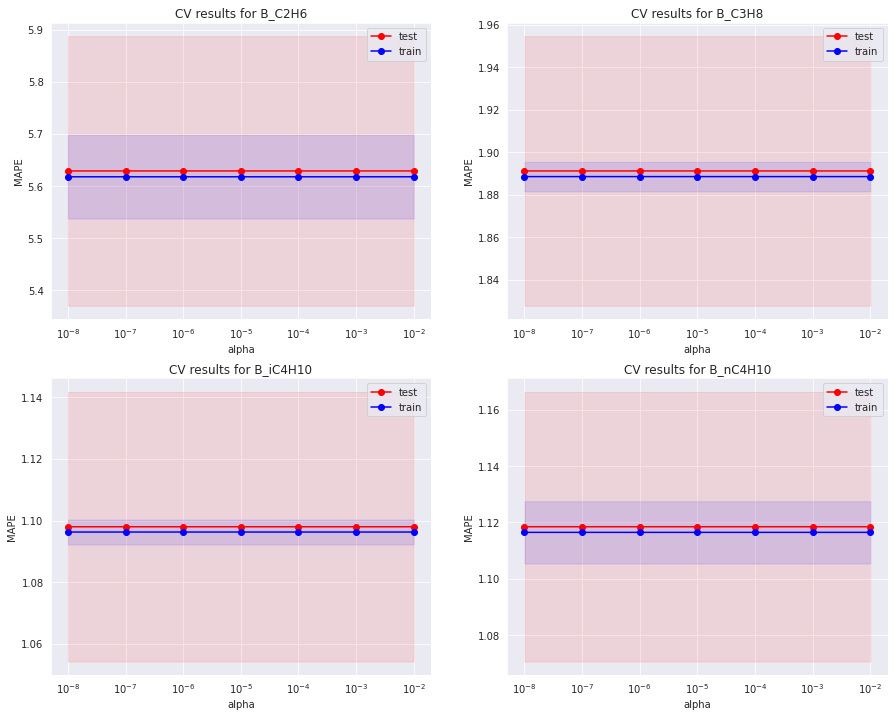

In [27]:
plot_cv_results([model.cv_results_ for model in trained_models], TARGET_COLUMNS)

In [28]:
y_fits = []
y_preds = []

for m in trained_models:
    result = m.predict(X)
    result_df = pd.DataFrame(result, index=X.index)

    y_fitted = result_df.loc[:"2020-04-30 23:30:00", :]
    y_pred = result_df.loc["2020-05-01 00:00:00":"2020-07-22 23:30:00", :]

    y_fits.append(y_fitted)
    y_preds.append(y_pred)

In [29]:
y_fits_df = pd.concat(y_fits, axis=1)
y_fits_df.columns = [f"{c}_fitted" for c in TARGET_COLUMNS]

fits = pd.concat(
    [y_fits_df, y_train.loc[:"2020-04-30 23:30:00":, :]], axis=1)

sub = pd.concat(y_preds, axis=1)
sub.columns = TARGET_COLUMNS

In [30]:
show_results(trained_models, fits)


==================== Train results ====================
scores: [5.618310226385443, 1.8886718570778136, 1.0963476331601065, 1.1165964765729914]
total score: 2.429981548299089
{'regressor__alpha': 1e-08}
{'regressor__alpha': 1e-08}
{'regressor__alpha': 0.01}
{'regressor__alpha': 1e-08}
========================= End =========================


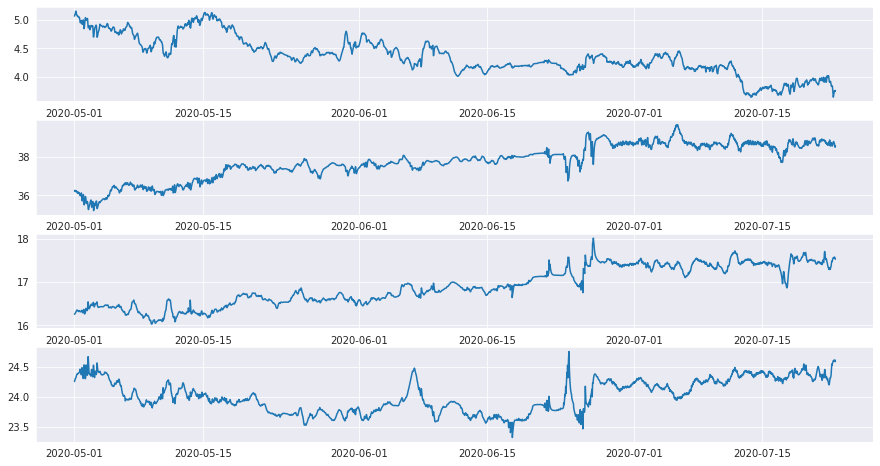

In [31]:
with sns.axes_style('darkgrid'):
    _, axes = plt.subplots(4, 1, figsize=(15, 8))
    for ax, tartget in zip(axes.flatten(), TARGET_COLUMNS):
        ax.plot(sub[tartget])